In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# automated feature engineering
import featuretools as ft


In [2]:
app_train = pd.read_csv('./home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
app_test = pd.read_csv('./home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
bureau = pd.read_csv('./home-credit-default-risk/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
bureau_balance = pd.read_csv('./home-credit-default-risk/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
cash = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
credit = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
previous = pd.read_csv('./home-credit-default-risk/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
installments = pd.read_csv('./home-credit-default-risk/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])

In [3]:
import featuretools as ft
import woodwork as ww

# Assuming app_train is your dataframe

# Initialize dictionaries for variable types
app_types = {}

# Iterate through the columns of app_train to identify Boolean variables and check for nulls
for col in app_train:
    if (app_train[col].dtype != 'object') and (len(app_train[col].unique()) <= 2):
        # Check if there are null values in the column
        if app_train[col].isnull().any():
            app_types[col] = ww.logical_types.BooleanNullable
        else:
            app_types[col] = ww.logical_types.BooleanNullable

for col, ltype in app_types.items():
    print(f"Column: {col}, Logical Type: {ltype}")


print('Number of boolean variables in app_train:', len(app_types))

Column: TARGET, Logical Type: BooleanNullable
Column: FLAG_MOBIL, Logical Type: BooleanNullable
Column: FLAG_EMP_PHONE, Logical Type: BooleanNullable
Column: FLAG_WORK_PHONE, Logical Type: BooleanNullable
Column: FLAG_CONT_MOBILE, Logical Type: BooleanNullable
Column: FLAG_PHONE, Logical Type: BooleanNullable
Column: FLAG_EMAIL, Logical Type: BooleanNullable
Column: REG_REGION_NOT_LIVE_REGION, Logical Type: BooleanNullable
Column: REG_REGION_NOT_WORK_REGION, Logical Type: BooleanNullable
Column: LIVE_REGION_NOT_WORK_REGION, Logical Type: BooleanNullable
Column: REG_CITY_NOT_LIVE_CITY, Logical Type: BooleanNullable
Column: REG_CITY_NOT_WORK_CITY, Logical Type: BooleanNullable
Column: LIVE_CITY_NOT_WORK_CITY, Logical Type: BooleanNullable
Column: FLAG_DOCUMENT_2, Logical Type: BooleanNullable
Column: FLAG_DOCUMENT_3, Logical Type: BooleanNullable
Column: FLAG_DOCUMENT_4, Logical Type: BooleanNullable
Column: FLAG_DOCUMENT_5, Logical Type: BooleanNullable
Column: FLAG_DOCUMENT_6, Logical 

In [4]:
app_train['REGION_RATING_CLIENT_W_CITY'] .unique()

array([2, 1, 3])

In [5]:
app_types['REGION_RATING_CLIENT'] = ww.logical_types.Ordinal(order=[1, 2, 3])
app_types['REGION_RATING_CLIENT_W_CITY'] = ww.logical_types.Ordinal(order=[1, 2, 3])

app_test_types = app_types.copy()
del app_test_types['TARGET']

In [6]:
previous_types= {'NFLAG_LAST_APPL_IN_DAY': ww.logical_types.BooleanNullable,
                 'NFLAG_INSURED_ON_APPROVAL': ww.logical_types.BooleanNullable}

In [7]:
import re

def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

In [8]:
app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)

In [9]:
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [10]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
0,-857 days,-492 days,-553 days,-155 days
1,-909 days,-179 days,-877 days,-155 days
2,-879 days,-514 days,-544 days,-155 days
3,-1572 days,-1329 days,-1328 days,-155 days
4,-559 days,902 days,NaT,-6 days


In [11]:
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

/var/folders/5n/v4r1bflj5gd3ry2xml0qlzsh0000gp/T/ipykernel_77106/2477983351.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);


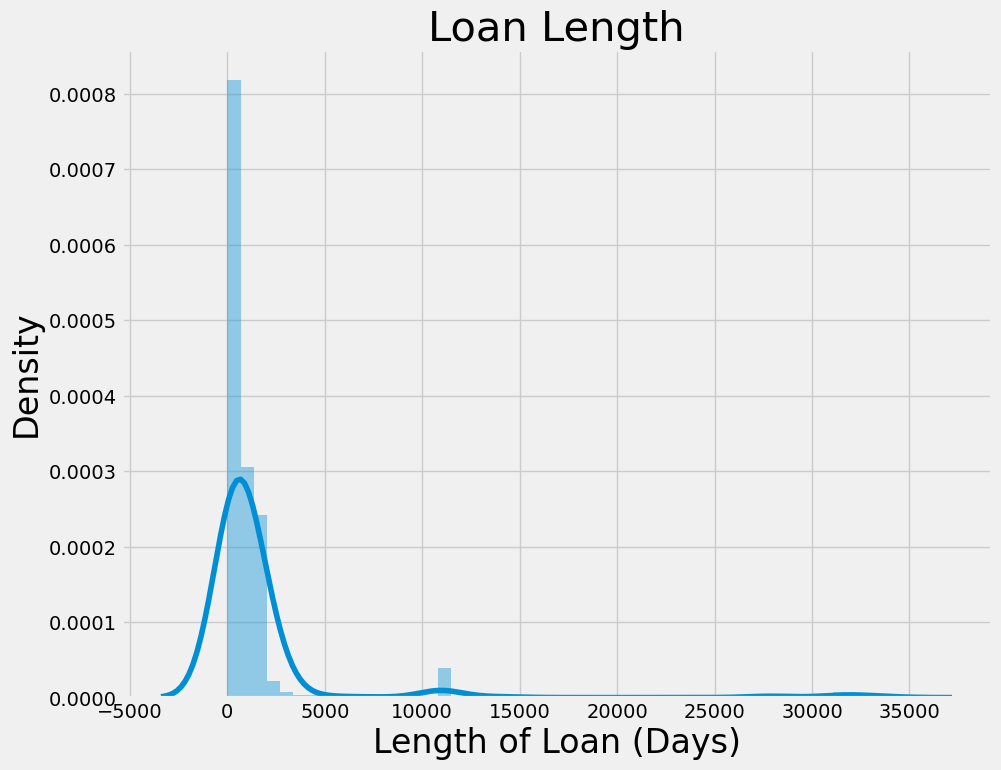

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

# Drop the time offset columns
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

In [13]:
bureau_balance['MONTHS_BALANCE'] 

0       -7
1       -3
2       -4
3       -5
4       -6
        ..
996     -7
997     -8
998     -9
999    -10
1000   -11
Name: MONTHS_BALANCE, Length: 1001, dtype: int64

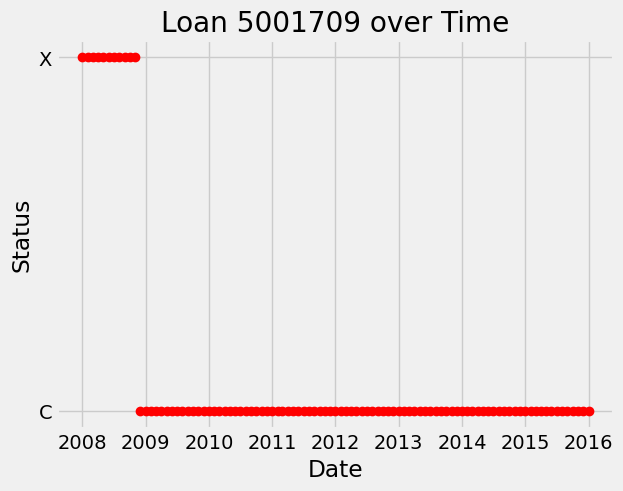

In [14]:
bureau_balance['bureau_balance_date'] = bureau_balance['MONTHS_BALANCE'].apply(
    lambda x: start_date + pd.offsets.DateOffset(months=x)
)
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])


# Plotting the status of a specific loan over time as an example
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro')
plt.title('Loan 5001709 over Time')
plt.xlabel('Date')
plt.ylabel('Status')
plt.show()

In [15]:
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[col] = pd.to_timedelta(previous[col], 'D')
    
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

In [16]:
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

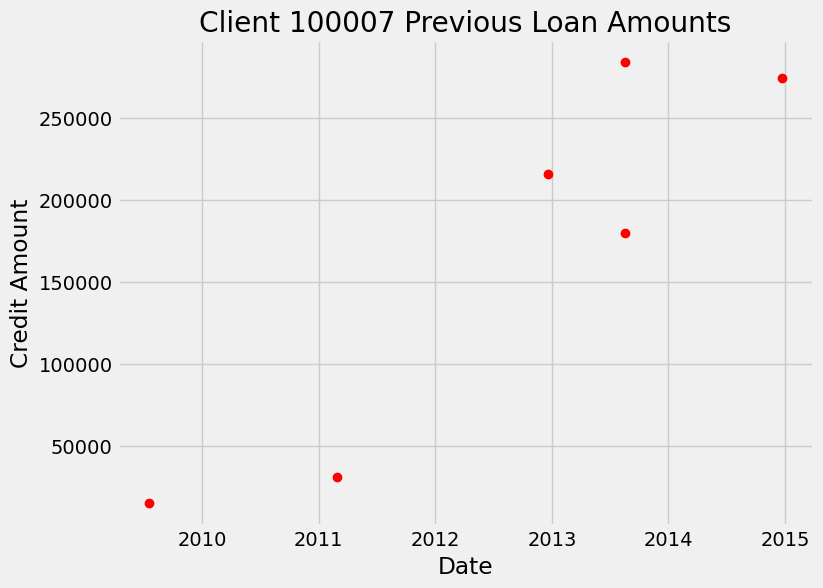

In [17]:
plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100007]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

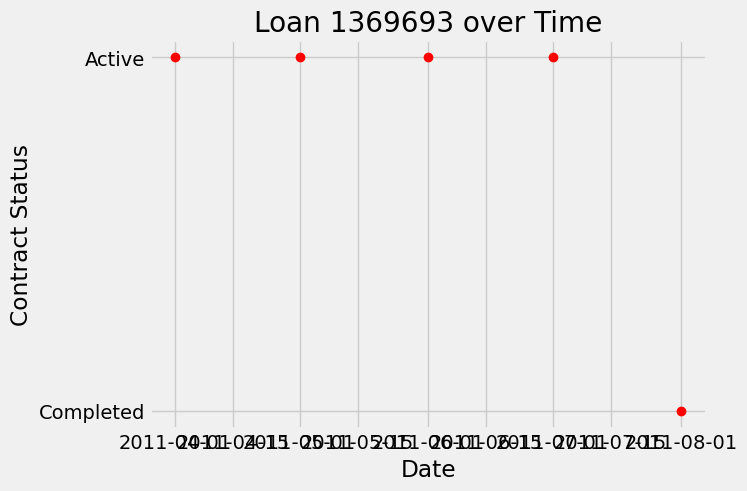

In [18]:
# Function to calculate the date from MONTHS_BALANCE
def calculate_date(months_balance):
    return start_date + pd.offsets.DateOffset(months=months_balance)

# Apply the function to the MONTHS_BALANCE column
credit['credit_balance_date'] = credit['MONTHS_BALANCE'].apply(calculate_date)
cash['cash_balance_date'] = cash['MONTHS_BALANCE'].apply(calculate_date)

# Drop the original 'MONTHS_BALANCE' column
credit = credit.drop(columns=['MONTHS_BALANCE'])
cash = cash.drop(columns=['MONTHS_BALANCE'])

# Select one loan and plot for cash DataFrame
example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro')
plt.title('Loan 1369693 over Time')
plt.xlabel('Date')
plt.ylabel('Contract Status')
plt.show()


In [19]:
cash[cash['SK_ID_PREV'] == 1369693]

,SK_ID_PREV,SK_ID_CURR,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,cash_balance_date
0,1369693,100001,4.0,0.0,Completed,0,0,2011-08-01
1,1369693,100001,4.0,1.0,Active,0,0,2011-07-01
2,1369693,100001,4.0,4.0,Active,0,0,2011-04-01
3,1369693,100001,4.0,2.0,Active,0,0,2011-06-01
4,1369693,100001,4.0,3.0,Active,0,0,2011-05-01


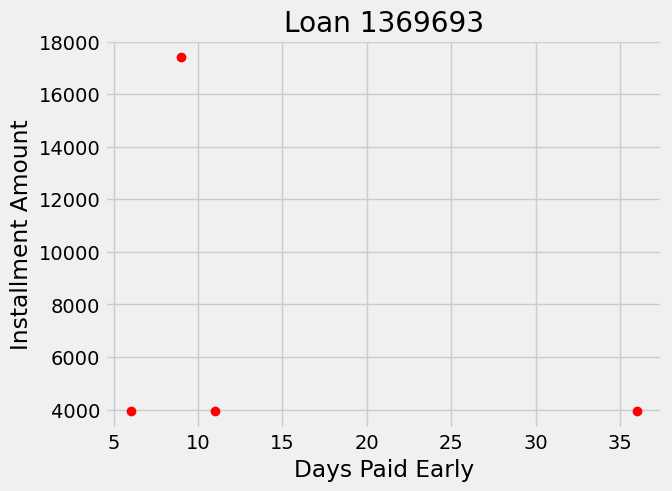

In [20]:
# Conver to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

# Select one loan and plot
example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');

In [21]:
es = ft.EntitySet(id = 'clients')

In [22]:
# Entities with a unique index
es = es.add_dataframe(dataframe_name = 'app_train', dataframe = app_train, 
                              index = 'SK_ID_CURR', logical_types = app_types
                              )

es = es.add_dataframe(dataframe_name = 'app_test', dataframe = app_test, 
                              index = 'SK_ID_CURR', logical_types = app_test_types)

es = es.add_dataframe(dataframe_name = 'bureau', dataframe = bureau, 
                              index = 'SK_ID_BUREAU', time_index='bureau_credit_application_date')

es = es.add_dataframe(dataframe_name = 'previous', dataframe = previous, 
                              index = 'SK_ID_PREV', time_index = 'previous_decision_date',
                              logical_types = previous_types)

# Entities that do not have a unique index
es = es.add_dataframe(dataframe_name = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bb_index',
                              time_index = 'bureau_balance_date')

es = es.add_dataframe(dataframe_name = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index',
                              time_index = 'cash_balance_date')

es = es.add_dataframe(dataframe_name = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index',
                              time_index = 'installments_paid_date')

es = es.add_dataframe(dataframe_name = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index',
                              time_index = 'credit_balance_date')

/Users/user/mambaforge/lib/python3.10/site-packages/woodwork/type_sys/inference_functions.py:27: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pdtypes.is_categorical_dtype(series.dtype):
/Users/user/mambaforge/lib/python3.10/site-packages/woodwork/type_sys/inference_functions.py:189: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  pdtypes.is_categorical_dtype(series.dtype)
/Users/user/mambaforge/lib/python3.10/site-packages/woodwork/type_sys/inference_functions.py:27: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pdtypes.is_categorical_dtype(series.dtype):
/Users/user/mambaforge/lib/python3.10/site-packages/woodwork/type_sys/utils.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated a

In [23]:
# Add the relationships to the EntitySet
es = es.add_relationship(parent_dataframe_name='app_train', 
                               parent_column_name='SK_ID_CURR', 
                               child_dataframe_name='bureau', 
                               child_column_name='SK_ID_CURR')
es = es.add_relationship(parent_dataframe_name='app_test', 
                               parent_column_name='SK_ID_CURR', 
                               child_dataframe_name='bureau', 
                               child_column_name='SK_ID_CURR')
es = es.add_relationship(parent_dataframe_name='bureau', 
                                   parent_column_name='SK_ID_BUREAU', 
                                   child_dataframe_name='bureau_balance', 
                                   child_column_name='SK_ID_BUREAU')
es = es.add_relationship(parent_dataframe_name='app_train', 
                                 parent_column_name='SK_ID_CURR', 
                                 child_dataframe_name='previous', 
                                 child_column_name='SK_ID_CURR')
es = es.add_relationship(parent_dataframe_name='app_test', 
                                 parent_column_name='SK_ID_CURR', 
                                 child_dataframe_name='previous', 
                                 child_column_name='SK_ID_CURR')
es = es.add_relationship(parent_dataframe_name='previous', 
                                  parent_column_name='SK_ID_PREV', 
                                  child_dataframe_name='cash', 
                                  child_column_name='SK_ID_PREV')
es = es.add_relationship(parent_dataframe_name='previous', 
                                          parent_column_name='SK_ID_PREV', 
                                          child_dataframe_name='installments', 
                                          child_column_name='SK_ID_PREV')
es = es.add_relationship(parent_dataframe_name='previous', 
                                    parent_column_name='SK_ID_PREV', 
                                    child_dataframe_name='credit', 
                                    child_column_name='SK_ID_PREV')

In [24]:
es

Entityset: clients
  DataFrames:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 1001, Columns: 121]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau.SK_ID_CURR -> app_test.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    previous.SK_ID_CURR -> app_test.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [28]:
time_features, time_feature_names = ft.dfs(entityset = es, target_dataframe_name = 'app_train', 
                                           trans_primitives = ['cum_sum', 'time_since_previous'], max_depth = 2,
                                           agg_primitives = ['trend'] ,
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_dataframes = ['app_test'])

Built 452 features
Elapsed: 00:05 | Progress: 100%|██████████


/Users/user/mambaforge/lib/python3.10/site-packages/woodwork/logical_types.py:684: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pdtypes.is_categorical_dtype(typed_ser.dtype):
/Users/user/mambaforge/lib/python3.10/site-packages/woodwork/logical_types.py:684: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pdtypes.is_categorical_dtype(typed_ser.dtype):


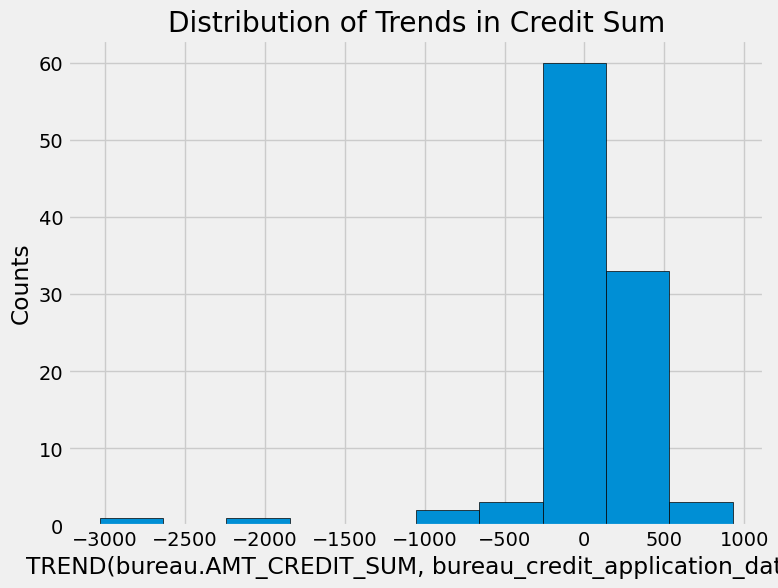

In [36]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Credit Sum');

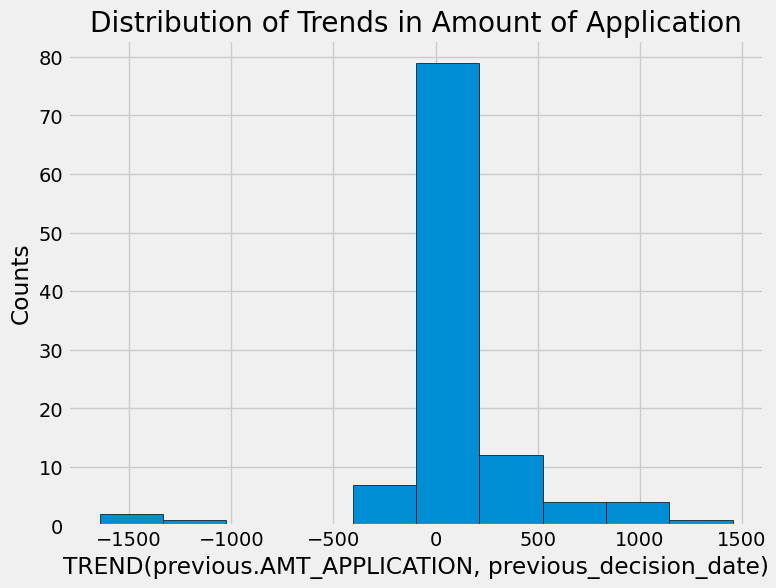

In [38]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(previous.AMT_APPLICATION, previous_decision_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(previous.AMT_APPLICATION, previous_decision_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Amount of Application');

In [39]:
time_feature_names[-10:]

[<Feature: CUM_SUM(TREND(previous.AMT_APPLICATION, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_CREDIT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_DOWN_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_GOODS_PRICE, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.CNT_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.HOUR_APPR_PROCESS_START, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_DOWN_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIMARY, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.SELLERPLACE_AREA, previous_decision_date))>]

In [40]:
previous['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: count, dtype: int64

In [41]:
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled']


In [45]:
interesting_features, interesting_feature_names = ft.dfs(entityset=es, target_dataframe_name='app_train', max_depth = 1, 
                                                         where_primitives = ['mean', 'mode'], 
                                                         trans_primitives=[], features_only = False, verbose = True,
                                                         chunk_size = len(app_train),
                                                         ignore_dataframes = ['app_test'])

/Users/user/mambaforge/lib/python3.10/site-packages/featuretools/synthesis/dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  where_primitives: ['mean', 'mode']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Built 276 features
Elapsed: 00:00 | Progress:  65%|██████▌   

/Users/user/mambaforge/lib/python3.10/site-packages/featuretools/computational_backends/feature_set_calculator.py:829: FutureWarning: The provided callable <function amin at 0x10c1fbc70> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  ).agg(to_agg)
/Users/user/mambaforge/lib/python3.10/site-packages/featuretools/computational_backends/feature_set_calculator.py:829: FutureWarning: The provided callable <function sum at 0x10c1fb250> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).agg(to_agg)
/Users/user/mambaforge/lib/python3.10/site-packages/featuretools/computational_backends/feature_set_calculator.py:829: FutureWarning: The provided callable <function std at 0x10c2048b0> is currently using SeriesGroupBy.std. In a future version of pandas, 

Elapsed: 00:00 | Progress: 100%|██████████


/Users/user/mambaforge/lib/python3.10/site-packages/featuretools/computational_backends/feature_set_calculator.py:839: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pdtypes.is_categorical_dtype(frame.index):
/Users/user/mambaforge/lib/python3.10/site-packages/woodwork/logical_types.py:684: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pdtypes.is_categorical_dtype(typed_ser.dtype):
/Users/user/mambaforge/lib/python3.10/site-packages/woodwork/logical_types.py:684: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pdtypes.is_categorical_dtype(typed_ser.dtype):


In [43]:
interesting_features.iloc[:, -6:, ].head()

,SUM(previous.CNT_PAYMENT),SUM(previous.HOUR_APPR_PROCESS_START),SUM(previous.RATE_DOWN_PAYMENT),SUM(previous.RATE_INTEREST_PRIMARY),SUM(previous.RATE_INTEREST_PRIVILEGED),SUM(previous.SELLERPLACE_AREA)
SK_ID_CURR,,,,,,
100002,24.0,9.0,0.000000,0.0,0.0,500.0
100003,30.0,44.0,0.100061,0.0,0.0,1599.0
100004,4.0,5.0,0.212008,0.0,0.0,30.0
100006,138.0,132.0,0.326824,0.0,0.0,8048.0
100007,124.0,74.0,0.319033,0.0,0.0,2455.0


In [51]:
# Initialize Woodwork for both Series
es['installments']['installments_due_date'].ww.init()
es['installments']['installments_paid_date'].ww.init()

late_payment = ft.Feature(es['installments']['installments_due_date'], entityset=es) < ft.Feature(es['installments']['installments_paid_date'], entityset=es)
late_payment = late_payment.rename("late_payment")


seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_dataframe_name = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [late_payment],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_dataframes=['app_test'])

TypeError: Feature.__new__() got an unexpected keyword argument 'entityset'